# <font color='violet'> Exploration & Parsing
Using prescription drug review data wrangled here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/1-kl-wrangle-tabular.ipynb

In [1]:
# ! pip install tqdm 
# !{sys.executable} -m pip install contractions

In [2]:
import numpy as np
import pandas as pd
import sys
import contractions
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
# prepare to add local python functions; import modules from src directory
src = '../src'
sys.path.append(src)

# import local functions
from nlp.parse import remove_accented_chars, strip_most_punc, strip_apostrophe

In [4]:
df = pd.read_csv('../data/interim/studies_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50652 non-null  int64  
 1   drug        50652 non-null  object 
 2   rating      50652 non-null  float64
 3   condition   50652 non-null  object 
 4   review      50652 non-null  object 
 5   date        50652 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.3+ MB


In [5]:
# Drop "Unnamed" column; it's redundant with the index
df = df.drop(columns=['Unnamed: 0'])
df.head(2)

,drug,rating,condition,review,date
0,vyvanse,9.0,add,I had began taking 20mg of Vyvanse for three m...,0
1,dextroamphetamine,8.0,add,Switched from Adderall to Dexedrine to compare...,0


<font color='violet'> Explore each column, starting with 'drug'

In [6]:
# How many drugs are in the data? 
len(df.drug.unique())

651

In [7]:
# Which drugs are most commonly reviewed?
freq_drugs = df.drug.value_counts().head(10)
freq_drugs

Sertraline      1855
Escitalopram    1714
Citalopram      1298
Bupropion       1278
Lexapro         1232
Venlafaxine     1212
Varenicline     1082
Zoloft          1075
Quetiapine      1065
Clonazepam      1004
Name: drug, dtype: int64

It would be best to add a 'drug class' column when I come to feature engineering so that all these drugs are categorized. That column existed previously but came from one of the origina tables where too few of the rows had reviews for psych meds. I could eventually do this by creating a dictionary of drugs and their classes using information scraped from this website: https://www.drugs.com/drug-classes.html

Alternatively, drugs could be understood by the conditions they treat. 

<font color='violet'> Explore conditions

In [8]:
len(df.condition.unique())

38

In [9]:
freq_conditions = df.condition.value_counts().head(10)
freq_conditions

depression                  14425
anxiety                     14114
bipolar                      5604
addiction                    5192
insomnia                     5018
hrt                          1456
schizophrenia                 789
ocd                           752
other                         592
schizoaffective disorder      523
Name: condition, dtype: int64

In [10]:
# Which of the most common drugs are used to treat which of the most common conditions?

freq_drugs = ['Sertraline', 'Escitalopram', 'Citalopram', 'Bupropion', 'Lexapro', 
             'Venlafaxine', 'Varenicline', 'Zoloft', 'Quetiapine', 'Clonazepam']
freq_conditions = ['depression', 'anxiety', 'bipolar', 'addiction', 'insomnia', 'hrt',
                  'schizophrenia', 'ocd', 'other', 'schizoaffective disorder']
freq_drug_conditions = df[df['drug'].isin(freq_drugs) & df['condition'].isin(freq_conditions)]

freq_drug_conditions.head()

,drug,rating,condition,review,date
118,Clonazepam,10.0,anxiety,"""klonopin has definitely given me my life back...","April 19, 2008"
120,Escitalopram,9.0,depression,"""I am a 22 year old female college student. I ...","April 29, 2014"
124,Clonazepam,6.0,anxiety,"""Works for me""","March 24, 2013"
127,Zoloft,1.0,depression,"""Zoloft did not help me at all. I was on it f...","January 14, 2013"
129,Sertraline,10.0,depression,"""I had major depression from the time I starte...","November 2, 2014"


In [11]:
freq_combo_summary = freq_drug_conditions.pivot_table(index='condition', columns='drug', 
                                                    aggfunc='count', values='review')
freq_combo_summary.columns = freq_drugs
freq_combo_summary = freq_combo_summary.sort_values(by=freq_drugs, ascending=False)
freq_combo_summary

,Sertraline,Escitalopram,Citalopram,Bupropion,Lexapro,Venlafaxine,Varenicline,Zoloft,Quetiapine,Clonazepam
condition,,,,,,,,,,
depression,893.0,536.0,NaN,566.0,443.0,131.0,763.0,NaN,692.0,464.0
addiction,199.0,NaN,17.0,NaN,NaN,NaN,NaN,1079.0,NaN,NaN
anxiety,85.0,709.0,782.0,1061.0,751.0,100.0,841.0,NaN,432.0,441.0
bipolar,41.0,8.0,77.0,33.0,25.0,396.0,32.0,NaN,51.0,11.0
other,5.0,5.0,7.0,5.0,NaN,7.0,4.0,3.0,5.0,NaN
hrt,3.0,14.0,NaN,8.0,3.0,NaN,36.0,NaN,3.0,30.0
ocd,NaN,21.0,2.0,35.0,10.0,17.0,105.0,NaN,12.0,80.0
insomnia,NaN,NaN,103.0,NaN,NaN,243.0,NaN,NaN,NaN,NaN
schizoaffective disorder,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN


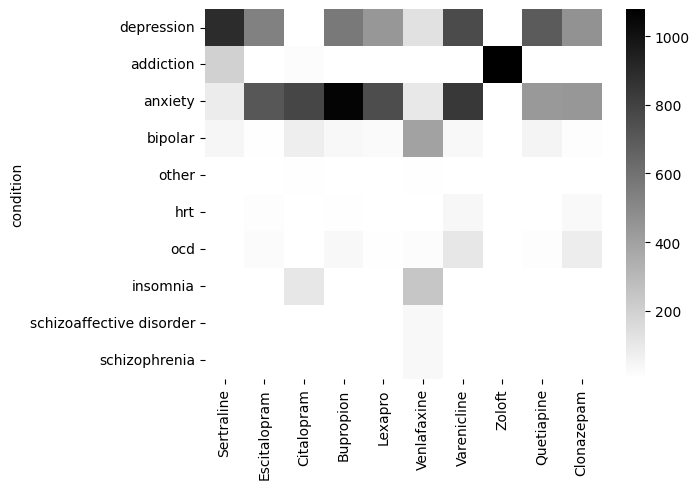

In [12]:
# Visualize distribution of reviews across common conditions & drugs with a heatmap.
sns.heatmap(freq_combo_summary, cmap='gray_r')
plt.show()

<font color='violet'> Which drugs & conditions have the highest ratings?

In [13]:
top_drugs = df.groupby(['drug'])['rating'].mean().sort_values(ascending=False)
top_drugs.head(80)

drug
Hydrochlorothiazide / olmesartan    10.000000
Undecylenic acid                    10.000000
Vivelle                             10.000000
Focalin XR                          10.000000
lorazepam                           10.000000
                                      ...    
Micrainin                           10.000000
Tiagabine                           10.000000
Seconal Sodium                      10.000000
Propofol                            10.000000
Alprazolam Intensol                  9.833333
Name: rating, Length: 80, dtype: float64

In [14]:
successful_conditions = df.groupby(['condition'])['rating'].mean().sort_values(
    ascending=False)
successful_conditions.head(10)

condition
sad                  9.421053
failure to thrive    9.333333
did                  9.000000
addiction            8.686826
eating disorder      8.209302
ocd                  8.082447
nightmares           8.000000
other                7.939189
anxiety              7.750531
ptsd                 7.685185
Name: rating, dtype: float64

In [15]:
top_combo = df.groupby(['drug', 'condition'])['rating'].mean().sort_values(
    ascending=False)
top_combo.head(140)

drug                 condition 
Effexor              asd           10.000000
Asendin              depression    10.000000
Niravam              depression    10.000000
dextrostat           add           10.000000
Tofranil             nightmares    10.000000
                                     ...    
Evzio                addiction     10.000000
Pseudoephedrine      other         10.000000
Pristiq              hrt           10.000000
Methadone            other          9.875000
Alprazolam Intensol  anxiety        9.833333
Name: rating, Length: 140, dtype: float64

In [16]:
top_freq_drugs = set(freq_drugs).intersection(set(top_drugs.index[0:79]))
top_freq_drugs

set()

In [17]:
top_freq_drugs_by_condition = set(freq_drugs).intersection(set(top_combo.index[0:138]))
top_freq_drugs_by_condition

set()

In [18]:
successful_freq_conditions = set(freq_conditions).intersection(set(
    successful_conditions.index[0:10]))
successful_freq_conditions

{'addiction', 'anxiety', 'ocd', 'other'}

Anxiety, addction, and ocd are conditions for which there are many drug reviews and high rates of success with treatment. 

The 10 most frequently-reviewed drugs have nothing in common with the 79 perfectly-rated drugs or the 138 drugs that are rated perfectly for any single condition. My hypothesis is that these drugs may have only one or very few reviews each, which is how their average rating is so high. 

<font color='violet'> Explore distribution of ratings

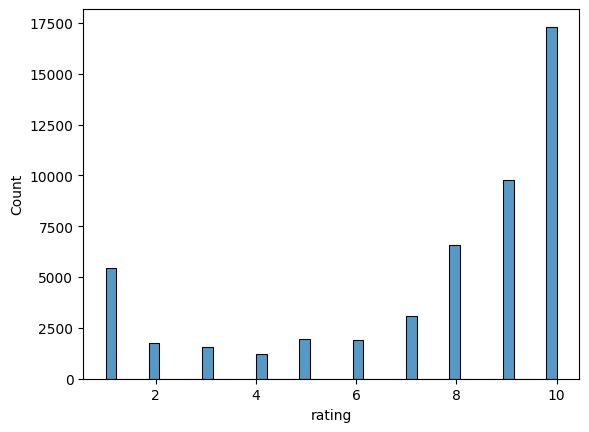

In [19]:
sns.histplot(df.rating)
plt.show()

More participants gave their drug a high review than gave low reviews, and even fewer gave mediocre reviews.

Now, find out: of drugs that received an average rating of 10, how many reiews is that mean derived from?

In [20]:
perfect_avg_rating = set(top_drugs.index[0:79])
df[df.drug.isin(perfect_avg_rating)].value_counts(subset='drug')[0:17]

drug
Secobarbital         6
Estratest H.S.       5
Magnesium citrate    4
Seconal              3
Estropipate          3
Seconal Sodium       3
Diazepam Intensol    3
Focalin XR           3
Cenestin             3
Tranxene SD          2
Ciprofloxacin        2
Eskalith-CR          2
Ogen                 2
Vivelle              2
Isotretinoin         2
chantix              2
Regadenoson          1
dtype: int64

Of the 79 drugs with perfect average ratings, only 16 of them had more than one rating, and only 3 of them had more than 3 ratings. Given that there are about 50500 ratings and 650 drugs, the average number of ratings per drug is about 80, so the perfectly-rated drugs definitely seem like outliers. I'd not be surprised if a model eventually has a difficult time correctly classifying the extreme ratings, but for now I'll just keep this in mind and see what happens. 

<font color='violet'> What does the distribution of ratings look like for drugs with at least 20 ratings (20 = 25% of the average number of ratings)?

In [21]:
df['ratings_count'] = df.groupby(['drug'])['drug'].transform('count')
df.sort_values('ratings_count')

,drug,rating,condition,review,date,ratings_count
19385,Silver sulfadiazine,9.0,other,"""Works well, but I get a bit short of breath a...","July 1, 2016",1
44539,Brisdelle,7.0,hrt,"""I have been on Brisdelle for 3 yrs now at fir...","August 24, 2016",1
44568,Dimethyl sulfoxide,10.0,other,"""I have used DMSO for many things related to p...","March 13, 2013",1
35596,Cholestyramine,10.0,other,"""I have used this for 1 year and have no side ...","February 26, 2011",1
9404,Hydrocortisone / neomycin / polymyxin b,1.0,other,"""I went to my doctor for earache relief and I ...","May 29, 2016",1
...,...,...,...,...,...,...
45820,Sertraline,10.0,anxiety,"""Worked wonders for me. Changed my life. I hav...","July 15, 2008",1855
11268,Sertraline,8.0,anxiety,"""I am on day 16 of 50mg and I am starting to f...","January 6, 2015",1855
29321,Sertraline,10.0,hrt,"""I was on Lexapro for almost 5 years for depre...","February 3, 2013",1855
43521,Sertraline,2.0,depression,"""I started taking this medicine over a week ag...","September 20, 2016",1855


In [22]:
twenty_plus_ratings = df[df.ratings_count>=20]
twenty_plus_ratings.sort_values('ratings_count')

,drug,rating,condition,review,date,ratings_count
20018,Budeprion XL,9.0,depression,"""I have been using Budeprion for about 3 month...","November 19, 2011",20
19072,Angeliq,10.0,hrt,"""I am 59 years old. I had all the symptoms of ...","October 27, 2016",20
19312,Memantine,1.0,alzheimers,"""My wife began the 4 stage process a couple of...","June 27, 2014",20
49228,Drospirenone / estradiol,10.0,hrt,"""Well it changed my life. I was only 43 and ev...","December 12, 2008",20
40570,Drospirenone / estradiol,2.0,hrt,"""Lots of side effects especially breast pain a...","January 5, 2016",20
...,...,...,...,...,...,...
19675,Sertraline,10.0,anxiety,"""My 18 year old son was diagnosed with panic d...","December 8, 2014",1855
34582,Sertraline,8.0,ptsd,"""As someone that HATES crowds &amp; dealing wi...","November 12, 2015",1855
29253,Sertraline,8.0,anxiety,"""Having suffered with severe depression &amp; ...","May 7, 2017",1855
34578,Sertraline,8.0,depression,"""I started taking this drug to battle mild dep...","July 29, 2016",1855


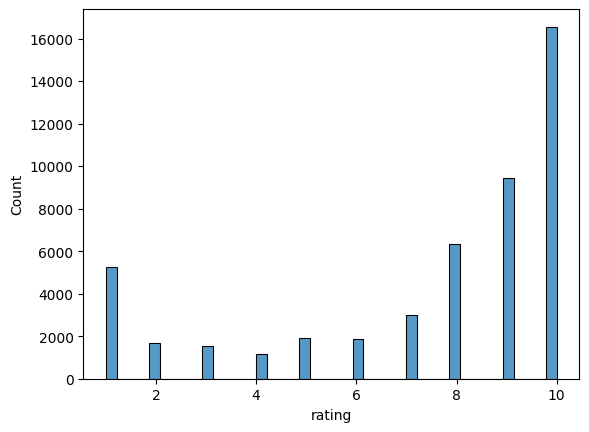

In [23]:
sns.histplot(twenty_plus_ratings.rating)
plt.show()

This distribution doesn't look grossly different from that which includes all reviews, so it's probably a good idea to keep all rows in the dataset when moving forward.  

<font color='violet'> What is the relationship between date and reviews?

In [24]:
df.date.unique()

array(['0', 'February 28, 2012', 'October 18, 2016', ...,
       'January 13, 2009', 'December 12, 2017', 'December 12, 2009'],
      dtype=object)

In [25]:
df.date = df.date.replace('0', np.nan)
df.date

0                      NaN
1                      NaN
2                      NaN
3                      NaN
4                      NaN
               ...        
50647    November 10, 2016
50648        July 17, 2016
50649      August 16, 2016
50650     January 21, 2015
50651         May 31, 2015
Name: date, Length: 50652, dtype: object

In [26]:
df.date = pd.to_datetime(df.date)
df.date

0              NaT
1              NaT
2              NaT
3              NaT
4              NaT
           ...    
50647   2016-11-10
50648   2016-07-17
50649   2016-08-16
50650   2015-01-21
50651   2015-05-31
Name: date, Length: 50652, dtype: datetime64[ns]

In [27]:
# Are there more or fewer reviews from any given point in time?
df['count_by_date'] = df.groupby(['date'])['date'].transform('count')
unique_dates = df.drop_duplicates(subset=['date'])
unique_dates.head()

,drug,rating,condition,review,date,ratings_count,count_by_date
0,vyvanse,9.0,add,I had began taking 20mg of Vyvanse for three m...,NaT,21,NaN
109,Mirtazapine,10.0,depression,"""I&#039;ve tried a few antidepressants over th...",2012-02-28,719,20.0
110,Methadone,7.0,addiction,"""Ive been on Methadone for over ten years and ...",2016-10-18,181,37.0
111,Seroquel,10.0,schizoaffective disorder,"""No problems, watch what you eat.""",2014-10-08,417,21.0
112,Ambien,2.0,insomnia,"""Ditto on rebound sleepless when discontinued....",2015-01-13,381,8.0


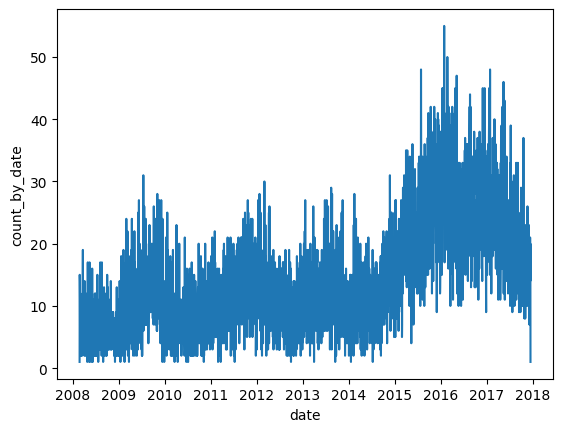

In [28]:
sns.lineplot(data=unique_dates, x='date', y='count_by_date')
plt.show()

There was an increase in the number of reviews submitted daily around 2015. 

<font color='violet'> Do ratings change with time?

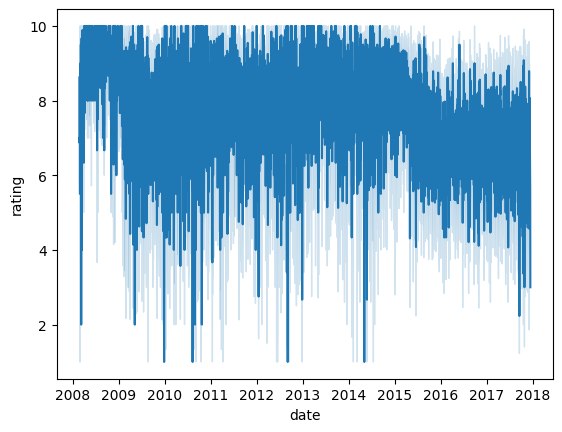

In [31]:
sns.lineplot(data=df, x='date', y='rating')
plt.show()

This looks like something other than total random noise, like maybe there were some current events happening around 2009 and again in 2015 that led people to start rating their psych meds less favorably. There may also be some annual seaonality. Whatever the reason, it seems that date could be correlated with rating and should not be removed. Process this column further to better understand the relationship between date and rating. 

In [36]:
rating_date = df[['date', 'rating']].dropna().set_index('date')
rating_date

,rating
date,
2012-02-28,10.0
2016-10-18,7.0
2014-10-08,10.0
2015-01-13,2.0
2015-02-14,10.0
...,...
2016-11-10,9.0
2016-07-17,2.0
2016-08-16,9.0


<AxesSubplot: xlabel='date'>

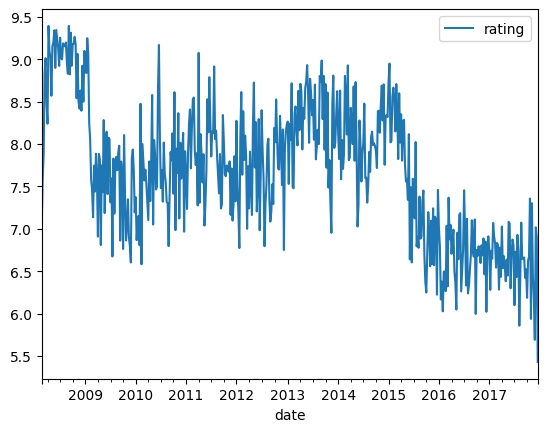

In [61]:
downsample_week = rating_date.resample('W').mean()
downsample_week.plot()

<AxesSubplot: xlabel='date'>

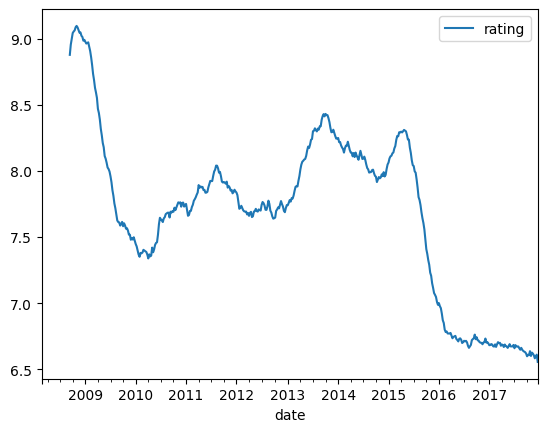

In [66]:
rolling_mean = downsample_week.rolling(window=30).mean()
rolling_mean.plot()

It is even more clear now that weekly average ratings of drugs in these studies did in facat dip in 2009 and again in 2015. The purpose behind these trends isn't so important (though I have some guesses as to what was happening in 2009 and 2015). The date, though, will be a valuable variable alongside narrataive text features when predicting ratings, so as to compare like with like current-events wise. 

Now, move from the more quantitative data into the narrative column, cleaning up language therein. 

<font color='violet'> Parse Language
    
The review column contains narratives where patients explain their experience with a prescription psych med. Language features from that column need to be extracted or created after any necessary cleaning of strings has been completed. Do any preparations necessary to conduct sentiment analysis. I'll be drawing quite a bit from the following resource: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

In [ ]:
# View a sample string. Search for special characters.
df.review[0]

In [ ]:
df[df['review'].str.find("é")!=-1].head(1)

In [ ]:
df[df['review'].str.find("ä")!=-1].head(1)

<font color='violet'> Remove Special Characters

...if there are any. Haven't been able to find any of the most common special characters é or ä in the data, but doing it just in case. 

In [ ]:
# This function works in the test suite, but there may not be examples in the data
df['review'] = df['review'].apply(remove_accented_chars)

<font color='violet'> Expand Contractions

In [ ]:
# First, find some to confirm it works. 
df[df['review'].str.find("'")!=-1].head(1)

In [ ]:
df.review[9]

In [ ]:
df['review'] = df['review'].apply(contractions.fix)
df.review[9]

"Don't" got changed to "do not"; contraction expansion worked. 

<font color='violet'> Next, remove punctuation/special characters where appropriate. 
    
Try to keep those correlated with sentiment: ! ? # % ;) :( .  Again, first find an example to confirm it works.

In [ ]:
df[df['review'].str.find("!")!=-1].head(1)

In [ ]:
df.review[6]

In [ ]:
strip_most_punc(df, 'review')
df.review[6]

In [ ]:
# left to strip are ' and : ; () where they don't appear as emoji.

df[df['review'].str.find("'")!=-1].head(1)

In [ ]:
df.review[16]

In [ ]:
strip_apostrophe(df, 'review')
df.review[16]

In [ ]:
# apostrophes stripped successfully. Move onto final characters. 

# use regex to identify :;() when they appear next to a letter rather than in emoji.

# Then isolate just the symbol itself for removal
# https://pynative.com/python-find-position-of-regex-match-using-span-start-end/

<font color='violet'> Lemmatize text

<font color='violet'> More EDA

https://medium.com/plotly/nlp-visualisations-for-clear-immediate-insights-into-text-data-and-outputs-9ebfab168d5b
    
https://www.numpyninja.com/post/nlp-text-data-visualization
    
https://www.kaggle.com/code/sainathkrothapalli/nlp-visualisation-guide
    
https://medium.com/acing-ai/visualizations-in-natural-language-processing-2ca60dd34ce
    
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
    
https://towardsdatascience.com/getting-started-with-text-nlp-visualization-9dcb54bc91dd
    
https://www.kaggle.com/code/mitramir5/nlp-visualization-eda-glove
    
https://medium.com/analytics-vidhya/how-to-begin-performing-eda-on-nlp-ffdef92bedf6
    
https://inside-machinelearning.com/en/eda-nlp/
    
https://towardsdatascience.com/fundamental-eda-techniques-for-nlp-f81a93696a75
    
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
    
https://www.kdnuggets.com/2019/05/complete-exploratory-data-analysis-visualization-text-data.html
    
